# How to add a new ablation model with atmosphere support

In [1]:
import ablate
print(ablate.__version__)

0.1.0


We cant create a new ablation model without also initializing a new `ATMOSPHERES` variable.

In [2]:
class A(ablate.AblationModel):
    def run(self, *args, **kwargs):
        pass

If we do, atmosphere registration is going to fail

In [3]:
A._register_atmosphere('my_atm', lambda x: None, {'my_meta':None})

TypeError: 'NoneType' object does not support item assignment

So we create a new model like this

In [4]:
class B(ablate.AblationModel):
    ATMOSPHERES = {}
    def run(self, *args, **kwargs):
        pass

We can then register a new atmosphere

In [5]:
print(f'Before: {B.ATMOSPHERES}')
B._register_atmosphere('my_atm', lambda x: None, {'my_meta':None})
print(f'After : {B.ATMOSPHERES}')

Before: {}
After : {'my_atm': (<function <lambda> at 0x7f67412d8700>, {'my_meta': None})}


And create a instance of that model

In [6]:
b = B(atmosphere='my_atm')
print(b)

If we try with a non-supported atmosphere it wont work

In [7]:
cool_b = B(atmosphere='cool_atm')

ValueError: "cool_atm" is not a supported by "<class '__main__.B'>"

We can also subclass existing ablation models, if we want them to inherrit the atmosphere support we simply do not override the `ATMOSPHERES` variable

In [8]:
class C(B):
    pass
print(f'C: {C.ATMOSPHERES}')

c = C(atmosphere='my_atm')
print(C)

C: {'my_atm': (<function <lambda> at 0x7f67412d8700>, {'my_meta': None})}
<class '__main__.C'>


There are also options to sublcass pre-defined extensions of `AblationModel` that provide different convenience, for example a class that wrapps the scipy `solve_ivp` method of solving Ordinary differential equations:

In [9]:
#Here we need to define the right-hand-side (rhs) of the differential equation as well.
class D(ablate.ScipyODESolve):
    ATMOSPHERES = {}
    
    def run(self, y0):
        return self.integrate(y0)

    def rhs(self, t, m, y):
        return -m

D._register_atmosphere('my_atm', lambda x: None, {'my_meta':None})

d = D(atmosphere='my_atm')

If we run the model it will solve the differential equation
$$
\frac{\mathrm{d}m}{\mathrm{d}t} = -m\\
\frac{\mathrm{d}y}{\mathrm{d}t} = 0
$$

In [10]:
import numpy as np
import matplotlib.pyplot as plt

result = d.run(np.array([1.0, 0]))

/home/danielk/.cache/pypoetry/virtualenvs/ablate-mCu_vN2k-py3.9/lib/python3.9/site-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `options`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [11]:
result

  message: 'A termination event occurred.'
     nfev: 151976
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f673c8b4970>
   status: 1
  success: True
        t: array([0.0000000e+00, 9.9900050e-04, 1.9990005e-03, ..., 2.5326999e+01,
       2.5327999e+01, 2.5328436e+01])
 t_events: [array([25.32843602])]
        y: array([[ 1.00000000e+00,  9.99001498e-01,  9.98002996e-01, ...,
         1.00143806e-11,  1.00043712e-11,  1.00000000e-11],
       [ 0.00000000e+00, -9.98501666e-04, -1.99700383e-03, ...,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]])
 y_events: [array([[ 1.e-11, -1.e+00]])]

Text(0.5, 1.0, 'example of new model')

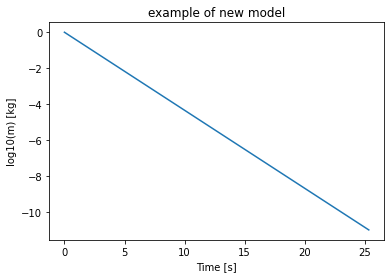

In [17]:
fig, ax = plt.subplots()
ax.plot(result.t, np.log10(result.y[0,:]))
ax.set_xlabel('Time [s]')
ax.set_ylabel('log10(m) [kg]')
ax.set_title('example of new model')